In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)


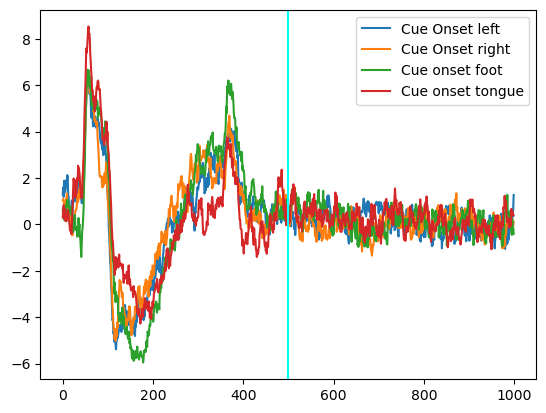

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:

## Random splitting

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = X_train_valid[ind_train], X_train_valid[ind_valid] 
y_train, y_valid = y_train_valid[ind_train], y_train_valid[ind_valid]

## Preprocessing the dataset

x_train, y_train = train_data_prep(X_train, y_train, 2, 2, True)
x_valid, y_valid = train_data_prep(X_valid, y_valid, 2, 2, True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
X_test_prep = test_data_prep(X_test)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1915, 22, 800)
Shape of X after maxpooling: (1915, 22, 400)
Shape of X after averaging+noise and concatenating: (3830, 22, 400)
Shape of X after subsampling and concatenating: (7660, 22, 400)
Shape of Y: (7660,)
Shape of X after trimming: (200, 22, 800)
Shape of X after maxpooling: (200, 22, 400)
Shape of X after averaging+noise and concatenating: (400, 22, 400)
Shape of X after subsampling and concatenating: (800, 22, 400)
Shape of Y: (800,)
Shape of training set: (7660, 22, 400)
Shape of validation set: (800, 22, 400)
Shape of training labels: (7660,)
Shape of validation labels: (800,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training labels after categorical conversion: (7660, 4)
Shape of validation labels after categorical conversion: (800, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7660, 22, 400, 1)
Shape of validation set after addi

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Reshape, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Define the input shape
inputs = Input(shape=(400,1,22))

# Conv. block 1
x = Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu')(inputs)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Conv. block 2
x = Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Conv. block 3
x = Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Conv. block 4
x = Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# FC+Transformer layers
x = Flatten()(x)
x = Dense(40, kernel_regularizer=l2(0.01))(x) # Add L2 regularization to the Dense layer
x = Reshape((40,1))(x)
x = MultiHeadAttention(num_heads=2, key_dim=2)(x, x) # Transformer layer

# Output layer with Softmax activation 
x = Flatten()(x) # Flatten the output of the Transformer layer
outputs = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x) # Add L2 regularization to the Dense layer

# Create the model
hybrid_cnn_transformer_model = Model(inputs=inputs, outputs=outputs)

# Printing the model summary
hybrid_cnn_transformer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 1,    │          0 │ -                 │
│ (InputLayer)        │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 1,    │      2,775 │ input_layer[0][0] │
│                     │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 134, 1,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 134, 1,    │        100 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 134, 1,    │          0 │ batch_normalizat… │
│                     │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 134, 1,    │      6,300 │ dropout[0][0]     │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 45, 1, 50) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 1, 50) │        200 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 45, 1, 50) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 1,     │     25,100 │ dropout_1[0][0]   │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 15, 1,     │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 1,     │        400 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 15, 1,     │          0 │ batch_normalizat… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 1,     │    100,200 │ dropout_2[0][0]   │
│                     │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 5, 1, 200) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 1, 200) │        800 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 1, 200) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 176,108 (687.92 KB)

 Trainable params: 175,358 (684.99 KB)

 Non-trainable params: 750 (2.93 KB)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compiling the model
hybrid_cnn_transformer_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint_path = r"C:\Users\15859\Desktop\Class\NNDL\Final_Project\models2\model_{epoch:02d}.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=False)

# Training and validating the model
hybrid_cnn_transformer_model_results = hybrid_cnn_transformer_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid),
             callbacks=[checkpoint], verbose=True)

Epoch 1/100
120/120 [==============================] - 6s 11ms/step - loss: 2.0980 - accuracy: 0.2749 - val_loss: 1.8768 - val_accuracy: 0.2037
Epoch 2/100
120/120 [==============================] - 1s 9ms/step - loss: 1.7173 - accuracy: 0.3148 - val_loss: 1.6894 - val_accuracy: 0.2300
Epoch 3/100
120/120 [==============================] - 1s 9ms/step - loss: 1.5110 - accuracy: 0.3518 - val_loss: 1.4859 - val_accuracy: 0.3425
Epoch 4/100
120/120 [==============================] - 1s 9ms/step - loss: 1.3933 - accuracy: 0.3979 - val_loss: 1.3879 - val_accuracy: 0.4487
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 1.3254 - accuracy: 0.4290 - val_loss: 1.4350 - val_accuracy: 0.3725
Epoch 6/100
120/120 [==============================] - 1s 9ms/step - loss: 1.2887 - accuracy: 0.4388 - val_loss: 1.3230 - val_accuracy: 0.4175
Epoch 7/100
120/120 [==============================] - 1s 9ms/step - loss: 1.2561 - accuracy: 0.4505 - val_loss: 1.3400 - val_accuracy: 0.436

Best test accuracy is 0.722347617149353 from model_72.h5


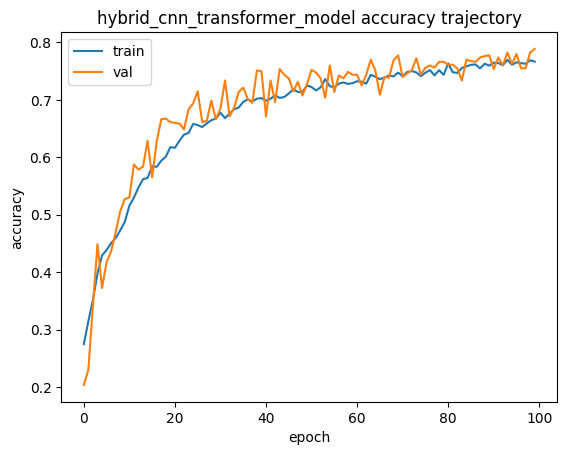

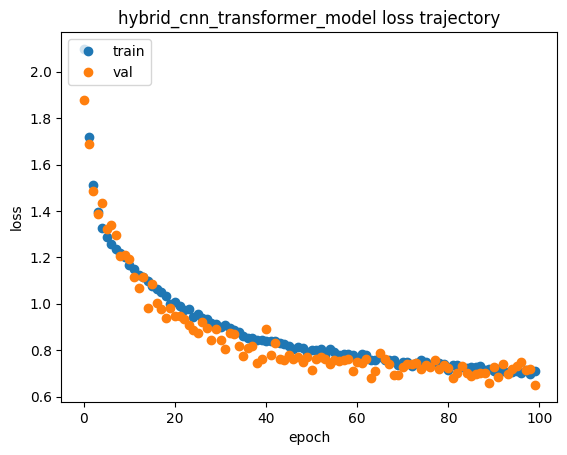

In [8]:
import os
from tensorflow.keras.models import load_model

# Directory where the models are saved
dir_path = r"C:\Users\15859\Desktop\Class\NNDL\Final_Project\models2"

# List all files in the directory
model_files = os.listdir(dir_path)

# Initialize the best score and the best model
best_score = 0
best_model_file = None

# For each file
for model_file in model_files:
    # Construct the full path of the file
    model_path = os.path.join(dir_path, model_file)
    
    # Load the model
    model = load_model(model_path)
    
    # Evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    
    # If this model's score is better than the current best score
    if score[1] > best_score:
        # Update the best score and the best model
        best_score = score[1]
        best_model_file = model_file

# Print the test accuracy of the best model
print(f'Best test accuracy is {best_score} from {best_model_file}')

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_transformer_model_results.history['accuracy'])
plt.plot(hybrid_cnn_transformer_model_results.history['val_accuracy'])
plt.title('hybrid_cnn_transformer_model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_transformer_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_transformer_model_results.history['val_loss'],'o')
plt.title('hybrid_cnn_transformer_model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()